<center> <h3><b> Assignment-2 </b></h3><br> Nandini Chinta <br> Sri Amarnath Mutyala  </center>

<i>We certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I did not receive any external help, coaching, or contributions
during the production of this work.</i>

<Center> <h3> <b>Part I - Exploring OpenAI </b></h3></center>

In [1]:
# For CCR and Google Co-lab
# !pip install pygame Box2D box2d-py gym torch opencv-python  gym[Box_2D]  --quiet



# import os
# import sys
# os.environ["SDL_VIDEODRIVER"] = "dummy"


In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
from collections import deque, OrderedDict
import torch
import torch.nn as nn
import random
import copy
from IPython import display
plt.style.use('ggplot')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

<h4> In this part we will explore the <a href="https://gym.openai.com/envs/CartPole-v1/"><b>CartPole-v1</b></a> environment and <a href="https://gym.openai.com/envs/LunarLander-v2/"><b>LunarLander-v2</b></a></h4>

In [8]:
# cartpole
env = gym.make('CartPole-v1')
env.reset()
for _ in range(1000):
    # env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

C:\Users\bitba\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\classic_control\cartpole.py:163: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


<center>Description</center>

`Name:`  
CartPole-v1

`Description:`  
Cart-pole system with continuous actions. We have an unactuated joint attached to a cart which can go linearly on a 1-D frictionless track. Our goal is to keep the pole upright with a degree of less than 12 from the vertical and the cart should not move beyond 2.4. 

`Source:`  
This environment of the cart-pole problem was first described by Barto, Anderson, and Sutton.

`Observation:`   
The state of the environment consists of the cart's x-position, cart's velocity, pole's angle in radians, and the angular velocity in rads/sec.

|No.|Observation|Minimum|Maximum|
|--- |--- |--- |--- |
|1|Cart's Poistion|-4.8|4.8|
|2|Cart's Velocity|-Infinity|Infinity|
|3|Pole Angle|-0.418 rad(-24 deg)|0.418 rad(24 deg)|
|4|Pole Angular Velocity|-Infinity|Infinity|

`Actions:`  
{0,1}. 0 action takes the cart to the left and 1 takes it to the right.

`Reward:`  

The reward is -1 for every step taken, and 0 if the cart-pole system is balanced. We want to motivate the agent to quickly reach the balancing.

`Starting State:`  

At the start, the cart is upright, and the pole lies at 20 degrees and has no velocity.

`Episode Termination:` 

Ends in Failure:  
pole angle > 12 degrees
cart position > 2.4 (out of bounds)
episdoe length > 200

Solved:  
average return > 195 over 100 consecutive trials.


<center>Validating the environment, actions, states, goals, rewards:</center>

In [9]:
# possible actions
print(env.action_space)

# observation space
print(env.observation_space)

# goals
print(env.spec.reward_threshold)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
475.0


<center> <b>LunarLander-v2</b></center>

In [10]:
# LunarLander random simulation
env = gym.make('LunarLander-v2')
env.reset()
for _ in range(1000):
    # env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

AttributeError: module 'gym.envs.box2d' has no attribute 'LunarLander'

`Name`   
LunarLander-v2

`Description`  
This environment explores the simulation of landing a space craft on the lunar surface. There are three engines on the bottom, both the sides of the spacecraft. The environment has discrete actions: engine on or off. There are two environment versions: on or off.
The landing pad is at the origin (0,0). The state vector is the co-ordinate position of the spacecraft in that frame. Fuel is infinite but each firing is penalized with a goal to help learn quick landings.


`Observation space`  
There are in total 8 states:

- `x-y`: cartesian coordinates of the lander
- `Vx-Vy`: Linear Velocities of the lander
- `theta`: Orientation angle of the lander
- 'Atheta': Angular velocities
-  'Cl,Cr': Booleans that say if lander's left and right legs are in contact with the ground.

`Action Space`  
     There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine

`Rewards`  
The reward function is defined as:

- Top of page to landing : 100-140 points
- If moving away from landing pad, it loses reward
- In case of a crash a reward of -100 is given.
- Each leg in contact with the ground is given +10 reward.
- Firing the main engine is -0.3 points for each frame and the side engines a penalty of -0.03 points.
- Correctly landing on the landing pad would be given a reward of +200 points.


`Starting State`  
The lander starts at the vertical top in the center.

`Episode Termination`   
The episode finishes if:
1) When the lander crashes into the surface.
2) the lander's x co-ordinate is > 1. (out of bounds)
3) the lander is not awake. (i.e. it doesn't move or do anything)

<center> <h3> <b> Part 2 - Applying DQN on the gridworld </b> </h3> </Center>

##### Defining our grid world

In [4]:
def set_grid(agent_pos, treasure):
    grid = np.full((5,5), -1.0)
    grid[tuple(agent_pos)] = 1
    grid[4,4] = treasure  #treasure
    grid[1,1] = 10  #gold1
    grid[1,3] = 10  #gold2
    grid[3,0] = 20  #mirage1
    grid[3,4] = 20  #mirage
    grid[2,2] = -10 #pit
    grid[3,2] = -5  #slide
    return grid

# 5*5 Grid World
class GridEnvt(gym.Env):
    metadata = { 'render.modes': []}

    class Spec:
        def __init__(self, name):
            self.id=  name


    def __init__(self, isStochastic):
        self.observation_space = spaces.Discrete(25)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20
        self.max_episode_steps = 20
        self.isStochastic = isStochastic
        print(F"Stochastic = {self.isStochastic}")
        self.isClipped = False
        self.actions = {0:"Left", 1: "Right", 2:"Up", 3:"Down"}
        self.spec = self.Spec('GridWorld')

    def reset(self, isStochastic=False):
        self.timestep = 0
        self.agent_pos = [0,0]
        self.agent_prev_pos = self.agent_pos
        self.treasure_pos = [4,4]
        self.gold1_pos = [1,1]
        self.gold2_pos = [1,3]
        self.mirage1_pos = [3,0]
        self.mirage2_pos = [3,4]
        self.pit_pos = [2,2]
        self.slide_pos = [3,2]
        self.slide_pos_moved = [3,3]
        #rewards & Penalties
        self.reward = 0.0
        self.treasure = 50.0
        self.gold1 = 5
        self.gold2 = 5
        self.mirage1 = 10
        self.mirage2 = 10
        self.pit = 5
        self.slide = 5
        self.state = set_grid(self.agent_pos, self.treasure)
        self.isG1Collected = False
        self.isG2Collected = False
        self.isM1Collected = False
        self.isM2Collected = False

        self.reward = 0

        self.isStochastic = isStochastic
        observation = self.state.flatten()
        return observation
    
    def get_distance(loc1, loc2):
        return np.linalg.norm((np.array(loc1) - np.array(loc2)))


    def step(self, action):
        self.reward = 0
        if action == 0: #left
            self.agent_pos[1] -=1
            # print(F"Going Away")
            self.reward -= 1
            # print(f"Reward = {self.reward}")
        elif action == 1: #right
            self.agent_pos[1] +=1
            # print(F"Going Closer")
            self.reward += 1
            # print(f"Reward = {self.reward}")
        elif action == 2: #up
            self.agent_pos[0] -=1
            # print(F"Going Away")
            self.reward -= 1
            # print(f"Reward = {self.reward}")
        elif action == 3: #down
            self.agent_pos[0] +=1
            # print(F"Going Closer")
            self.reward += 1
            # print(f"Reward = {self.reward}")
        
        self.isIn = all(0 <= x <= 4 for x in self.agent_pos)

        if not self.isIn:
            self.reward -= 2
            # print(f"Agent tried to go out of boundaries. Penalty = -5. Reward updated = {self.reward}")

        self.agent_pos = np.clip(self.agent_pos, 0, 4)

        #mirage
        # if all(np.array_equal(self.agent_pos,self.mirage1_pos), self.isM1Collected==False):
        if np.array_equal(self.agent_pos,self.mirage1_pos):
            if  self.isM1Collected==False:
                self.reward += self.mirage1
                self.mirage1_pos = [-1, -1]
                self.isM1Collected = True

        # if all(np.array_equal(self.agent_pos,self.mirage2_pos), self.isM2Collected==False):
        if np.array_equal(self.agent_pos,self.mirage2_pos):
            if self.isM2Collected==False:
                self.reward += self.mirage2
                self.mirage2_pos = [-1, -1] 
                self.isM2Collected = True  
                # print(f"Mirage2. {self.reward}")     

        #pit
        if (self.agent_pos == self.pit_pos).all():
            # print(f"Fell into pit. Penalty = -10.  ")
            self.reward -= self.pit
            # print(f"Update Reward = {self.reward}")
            # print(f"Pit - isStochastic = {self.isStochastic}")
            if self.isStochastic:
                # print(f"Pit - isStochastic = {self.isStochastic}")
                r = np.random.randint(3)
                self.agent_pos = [r, (np.random.randint(3) if r!=2 else np.random.randint(2))]
                        #Agent goes to any of the states except pit in [1,2,3,6,7,8,11,12]

        #slide
        if np.array_equal(self.agent_pos, self.slide_pos):
            if self.isStochastic:
                print(f"Stochastic Envt")
                print("Slide.")
                if(np.random.random()<=0.1):
                    print(f"Slide to {self.slide_pos_moved} position. Penalty={self.slide}")
                    self.agent_pos = self.slide_pos_moved
                    self.reward -= self.slide
                else:
                    print(f"Safe! No penalty for Slide.")
        
        # reward = 0
        if np.array_equal(self.agent_pos, self.treasure_pos):
            self.reward += 50
            # print(f"Found treasure. Reward = {self.reward}")
        # elif all(np.array_equal(self.agent_pos, self.gold1_pos),self.isG1Collected==False):
        elif np.array_equal(self.agent_pos, self.gold1_pos):
            if self.isG1Collected==False:
                self.reward += self.gold1
                self.gold1_pos = [-1,-1]
                self.isG1Collected = True
            # print(f"Found gold1. Reward = {self.reward}")
        # elif all(np.array_equal(self.agent_pos, self.gold2_pos), self.isG2Collected==False):
        elif np.array_equal(self.agent_pos, self.gold2_pos):
            if self.isG2Collected==False:
                self.reward += self.gold2
                self.gold2_pos = [-1,-1]
                self.isG2Collected = True
            # print(f"Found gold2. Reward = {self.reward}")

        self.state = set_grid(self.agent_pos, self.treasure)
        observation = self.state.flatten()

        self.timestep += 1
        # print(f"timestep: {self.timestep}\t Agent position: {self.agent_pos}")
        done = True if (self.timestep >= self.max_timesteps) or np.array_equal(self.agent_pos,self.treasure_pos) else False
        # if done:
            # if self.timestep >= self.max_timesteps:
                # print("Max Timesteps reached!!")
            # elif np.array_equal(self.agent_pos,self.treasure_pos):
                # print(f"Treasure Acquired!! At timestep-{self.timestep}")
        info = {}

        return observation,self.reward,done,info        
    
    def render(self):
        plt.imshow(self.state)
    
    def plot_graph(self,x,y,x_label,y_label,title):
        plt.plot(x,y,x_label,y_label,title)
        plt.show()

    def get_state(self):
        # 1. goal
        # 2. gold
        # 3. penalty
        # 4. Agent
        layer_goal = np.zeros((5,5))
        layer_goal[4,4] = 1

        layer_gold = np.zeros((5,5))
        layer_gold[1,1] = 1
        layer_gold[3,0] = 1
        layer_gold[1,3] = 1
        layer_gold[3,4] = 1

        layer_penalty = np.zeros((5,5))
        layer_penalty[2,2] = 1

        layer_agent = np.zeros((5,5))
        layer_agent[self.agent_pos[0], self.agent_pos[1]] = 1
        return np.array([layer_agent, layer_gold, layer_penalty, layer_goal])



In [6]:
env = GridEnvt(False)
env.reset()
env.get_state()

Stochastic = False


array([[[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]]])

In [ ]:
# Training the DQN. Has experience replay.

def plot_rewards(rewards,  goal_threshold_score, goal_threshold_episodes, enviroment_name, algorithm_name):
    display.clear_output(wait=True)
    # plot last 50 rewards handle 0 case
    if len(rewards) < goal_threshold_episodes:
        plt.plot(rewards)
    else:
        plt.plot(rewards[-goal_threshold_episodes:])

    # plot a goal line in red at 475
    plt.title(f"{enviroment_name} - {algorithm_name} Last {goal_threshold_episodes} episodes")
    plt.ylabel('Reward')
    plt.xlabel('-Episode')
    plt.plot([goal_threshold_score]*len(rewards), 'g', label='Goal')
    plt.legend()
    plt.show()

def train_model(env, model, loss_function, state_function , goal_threshold_score, goal_threshold_episodes, isDDQN = False,  replay_buffer_size = 5000, batch_size = 256, gamma = 0.89,  epochs = 3000, epsilon = 1, epsilon_decay = 0.99, epsilon_min = 0.001, 
update_target_every = 50 ):
  total_reward_list = []
  epsilons_epoch = []
  epsilons_epoch.append(epsilon)
  replay_buffer = deque(maxlen=replay_buffer_size)

  target_model = copy.deepcopy(model)
  target_model.load_state_dict(model.state_dict())
  
  j = 0

  episode_total = 0
  for i in range(epochs):
      episode_total = i + 1
      total_reward = 0
      s = env.reset()
      
      # one hot encoding
      state_1 = state_function(env, s)

      while(True):

          q_1 = model(state_1)

          # Take random action with probability epsilon or take the Q-network prediction in others
          if (random.random() < epsilon):
              action_1 = env.action_space.sample()
          else:
              action_1 = np.argmax(q_1.to('cpu').data.numpy())

          observation, reward, done, info = env.step(action_1)
          total_reward = total_reward + reward
    
          state_2 = state_function(env, observation)
          replay_buffer.append((state_1, action_1, reward, state_2, done))

          if(len(replay_buffer) >= batch_size):

                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*random.sample(replay_buffer, batch_size))
                state_batch = torch.cat(state_batch).to(device)
                action_batch = torch.Tensor(action_batch).to(device)
                reward_batch = torch.Tensor(reward_batch).to(device)
                next_state_batch = torch.cat(next_state_batch).to(device)
                done_batch = torch.Tensor(done_batch).to(device)

                q_1 = model(state_batch)
         
                X = q_1.gather(1, action_batch.long().unsqueeze(1)).squeeze(1)

                if(isDDQN):
                    th_t = model(next_state_batch)
                    max_action = torch.argmax(th_t, dim=1)
                    th_t_ = target_model(next_state_batch)
                    
                    # Y = reward_batch + gamma * (1 - done_batch) * th_t_[range(batch_size), max_action]
                    Y = reward_batch + gamma * (1 - done_batch) *  th_t_.gather(1, max_action.long().unsqueeze(1)).squeeze(1)
                   
                else:
                    q_2 = target_model(next_state_batch)
                    Y = reward_batch + gamma * (1 - done_batch) * torch.max(q_2,  dim= 1)[0]

                loss = loss_function(X, Y.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        

          state_1 = state_2
          j += 1
          if(j % update_target_every == 0):
              target_model.load_state_dict(model.state_dict())

          if done:
              break
      
      plot_rewards(total_reward_list, goal_threshold_score, goal_threshold_episodes, env.unwrapped.spec.id, 'Double DQN' if isDDQN else 'DQN')
      
      print(f"Epoch: {i} \t Total Reward: {total_reward} \t Epsilon: {epsilon}")
      total_reward_list.append(total_reward)

      # stop if goal is reached

      goal_threshold = lambda rewards:  len(rewards) > goal_threshold_episodes and np.mean(rewards[- goal_threshold_episodes:]) > goal_threshold_score

      if goal_threshold(total_reward_list):
            print("Goal Reached!!")
            break
    
      epsilon = max(epsilon * epsilon_decay, epsilon_min)
      epsilons_epoch.append(epsilon)
    
  return episode_total, total_reward_list, epsilons_epoch

In [137]:
def test_model(model, episodes, env, state_function):
    status_list = []
    total_reward_list = []
    for i in range(episodes):
        total_reward = 0
        s = env.reset()
        state = state_function(env, s)
        total_reward = 0
        step = 0
        while(True):
            step+=1
            QApprox = model(state)
            greedy_action_ = np.argmax(QApprox.to('cpu').data.numpy())
            # print(f'For Step : {step}; Taking action: {greedy_action_}')
            observation, reward, done,_ = env.step(greedy_action_)
            total_reward += reward
            state = state_function(env, observation)
            if done:
                env.render()
                status_list.append(True)
                break
            # if step > env.max_timesteps:
            #     env.render()
            #     status_list.append(False)
            #     break

        total_reward_list.append(total_reward)
    return status_list, total_reward_list

In [138]:
def visualize_training(total_reward_list, epochs, epsilons_epoch, environment_name, algorithm_name):
    plt.figure(figsize=(10,10))

    plt.title(f'{environment_name}-{algorithm_name} Rewards with epoch')
    plt.plot(range(1, epochs + 1),total_reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards per Epoch')
    plt.show()

    plt.plot(range(epochs), epsilons_epoch)
    plt.title(f'{environment_name}-{algorithm_name} with  Epsilon Decay')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilons')
    plt.legend()
    plt.show()

def visualize_testing(epochs, rewards, environment_name, algorithm_name):
    plt.show()
    plt.plot(range(epochs), rewards)
    plt.title(f'{environment_name}-{algorithm_name} Episodic Reward on trained agent')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()

def build_model(hyperparameters):
    dict = OrderedDict()
    dict.update({'Input layer': torch.nn.Linear(hyperparameters['state_dim'], hyperparameters['layer_dim'][0])})
    dict.update({f'ReLU 0': torch.nn.ReLU()})

    #  Make torch neural network from layer_dim and hidden_dim 
    for i in range(len(hyperparameters['layer_dim'])-1):
        dict.update({f'Hidden layer {i+1}': torch.nn.Linear(hyperparameters['layer_dim'][i], hyperparameters['layer_dim'][i+1])})
        # activation function
        dict.update({f'ReLU {i+1}': torch.nn.ReLU()})

    dict.update({'Output layer': torch.nn.Linear(hyperparameters['layer_dim'][-1], hyperparameters['action_dim'])})
    return torch.nn.Sequential(dict)
    


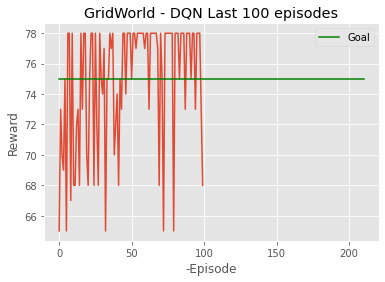

Epoch: 211 	 Total Reward: 73 	 Epsilon: 0.11995712819347792
Goal Reached!!


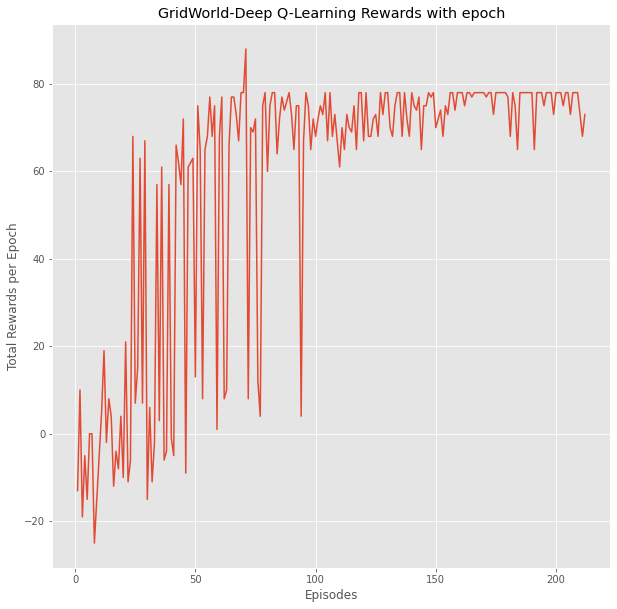

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


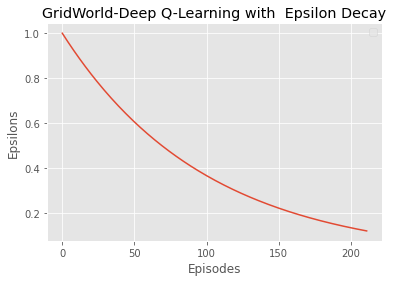

Stochastic = False


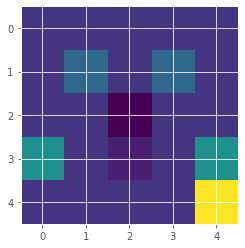

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


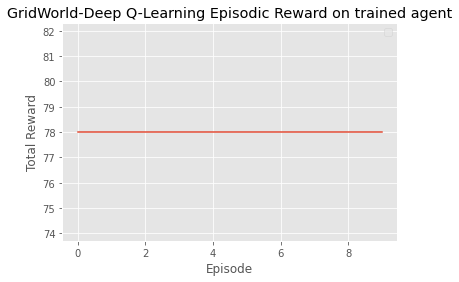

In [139]:
# 1.a) Training Deep Q-Learning model on the grid world

model = torch.nn.Sequential( OrderedDict([('layer-1', torch.nn.Linear(100, 175)), ('relu-1',torch.nn.ReLU()), ('layer-2',torch.nn.Linear(175, 150)), ('relu-2',torch.nn.ReLU()),('last',torch.nn.Linear(150,4))]))
optimizer = torch.optim.Adam(model.parameters(), lr= 2e-4)
loss_function = torch.nn.MSELoss()
model.to(device)

print('\x1B[31m',"Our Q-Network is as follows:",'\x1B[0m')
print('',model)

state_function = lambda env, curr_state: torch.from_numpy(env.get_state().reshape(1,100) + np.random.random()).float().to(device)


epochs,total_reward_list_dqn,epsilons_epoch_dqn =  train_model(GridEnvt(False), model, loss_function, state_function= state_function, 
goal_threshold_score = 75, goal_threshold_episodes = 100)

visualize_training(total_reward_list_dqn, epochs, epsilons_epoch_dqn, 'GridWorld', 'Deep Q-Learning')

test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = GridEnvt(False), state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'GridWorld', 'Deep Q-Learning')


<center> <b> Grid World with Double Deep Q-learning </b> </center>

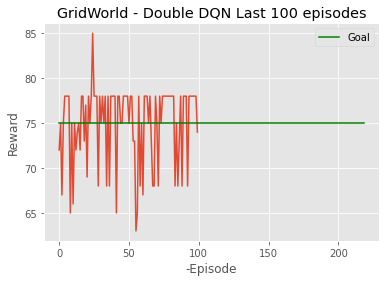

Epoch: 219 	 Total Reward: 78 	 Epsilon: 0.11068980359934164
Goal Reached!!


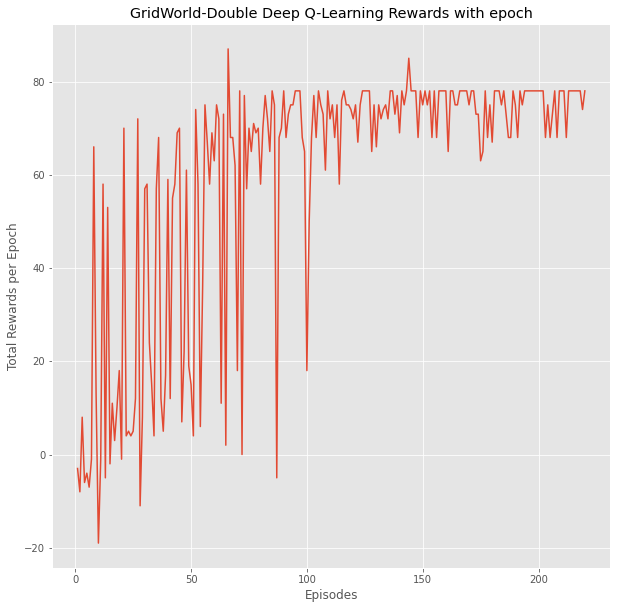

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


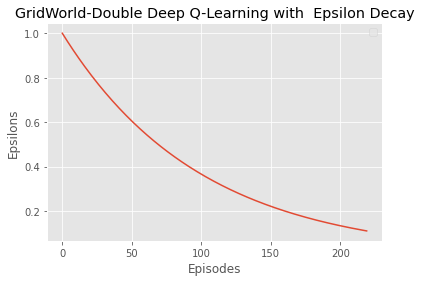

Stochastic = False


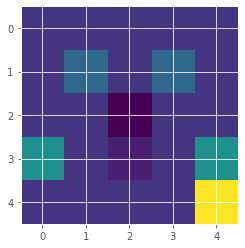

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


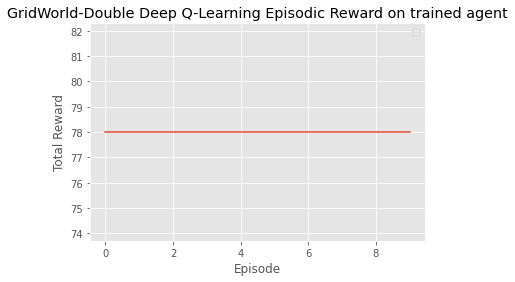

In [140]:
# 1.b) Training Double Deep Q-Learning model on the grid world

epochs,total_reward_list_ddqn,epsilons_epoch_ddqn =  train_model(GridEnvt(False), model, loss_function, state_function= state_function,
isDDQN=True, goal_threshold_score = 75, goal_threshold_episodes = 100)

visualize_training(total_reward_list_ddqn, epochs, epsilons_epoch_ddqn, 'GridWorld', 'Double Deep Q-Learning')

test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = GridEnvt(False), state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs, test_reward_list, 'GridWorld', 'Double Deep Q-Learning')

env.close()

<center>Comparing DQN and DDQN performance on GridWorld</center>

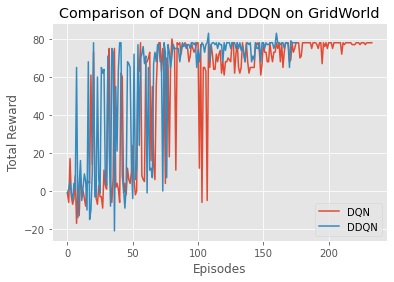

In [108]:
# comparing dqn and ddqn on the Grid world

plt.plot(range(len(epsilons_epoch_dqn)), total_reward_list_dqn, label='DQN')
plt.plot(range(len(epsilons_epoch_ddqn)), total_reward_list_ddqn, label='DDQN')
plt.title('Comparison of DQN and DDQN on GridWorld')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

<Center><b>Cartpole-v1</b></center>

In [113]:
# Cartpole-v1 random simulation
env = gym.make('CartPole-v1')
env.reset()

for _ in range(1000):
    # len(env.render('rgb_array'))
    env.step(env.action_space.sample()) # take a random action
env.close()

CartPole-v1


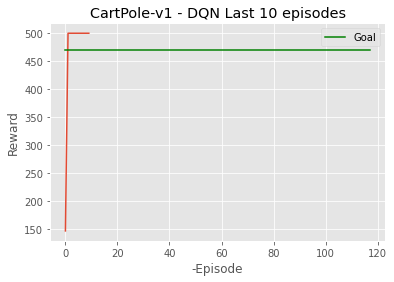

Epoch: 118 	 Total Reward: 500.0 	 Epsilon: 0.06606934480075947
Goal Reached!!


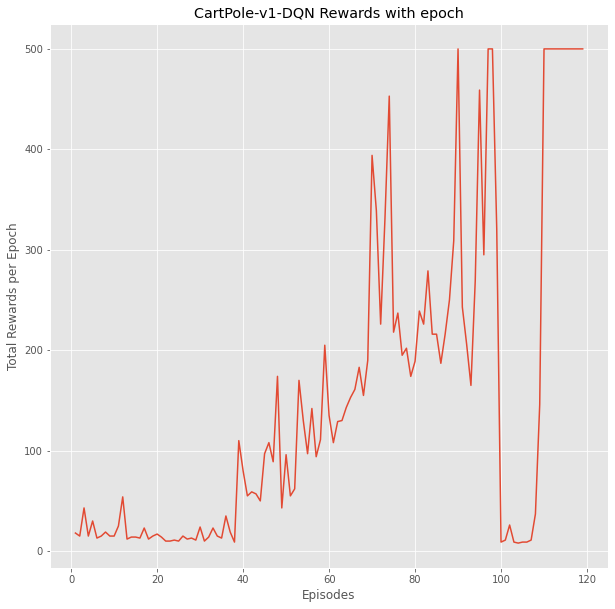

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


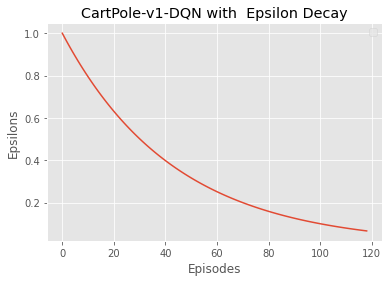

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


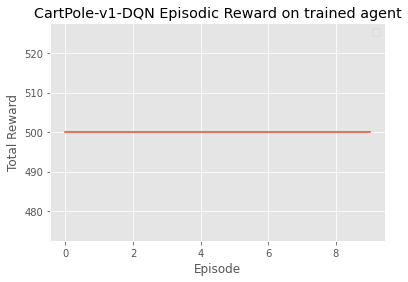

In [148]:
# Applying DQN on CartPole-v1

env = gym.make('CartPole-v1')
env.reset()

hyperparameters = {
    'state_dim': env.observation_space.shape[0],
    'action_dim': env.action_space.n,
    'layer_dim': [32,24],
    'lr': 0.001,
    'episodes': 200,
    'gamma': 0.99,
    'replay_batch_size': 128,
    'epsilon': 1,
    'epsilon_min': 0.001,
    'replay_buffer_size': 5000,
    'update_target_every': 4,
    'goal_threshold_score': 470,
    'goal_threshold_episodes': 10,
}

model = build_model(hyperparameters)
model.to(device)

print(model)

optimizer = torch.optim.Adam(model.parameters(), hyperparameters['lr'])

loss_function = torch.nn.MSELoss()

state_function = lambda env, curr_state: curr_state.to(device) if torch.is_tensor(curr_state) else torch.from_numpy(curr_state.reshape(1,4)).float().to(device)

epochs,total_reward_list_dqn, epsilons_epoch_dqn =  train_model(env, model, loss_function, state_function= state_function, epochs= hyperparameters['episodes'], gamma= hyperparameters['gamma'], epsilon= hyperparameters['epsilon'],
 replay_buffer_size= hyperparameters['replay_buffer_size'], 
 batch_size = hyperparameters['replay_batch_size'], update_target_every= hyperparameters['update_target_every'],
  epsilon_min= hyperparameters['epsilon_min'], 
 epsilon_decay= (0.01 / 1)**(1/hyperparameters['episodes']), goal_threshold_score = hyperparameters['goal_threshold_score'] ,goal_threshold_episodes =  hyperparameters['goal_threshold_episodes'] )

visualize_training(total_reward_list_dqn, epochs, epsilons_epoch_dqn, 'CartPole-v1', 'DQN')
test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = env, state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'CartPole-v1', 'DQN')



<center>Double DQN on Cartpole-v1</center>

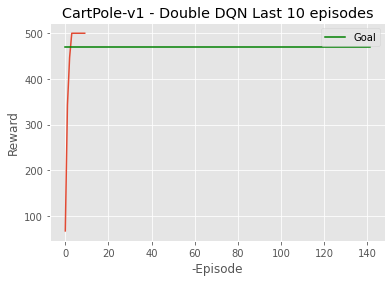

Epoch: 142 	 Total Reward: 461.0 	 Epsilon: 0.03801893963205602
Goal Reached!!


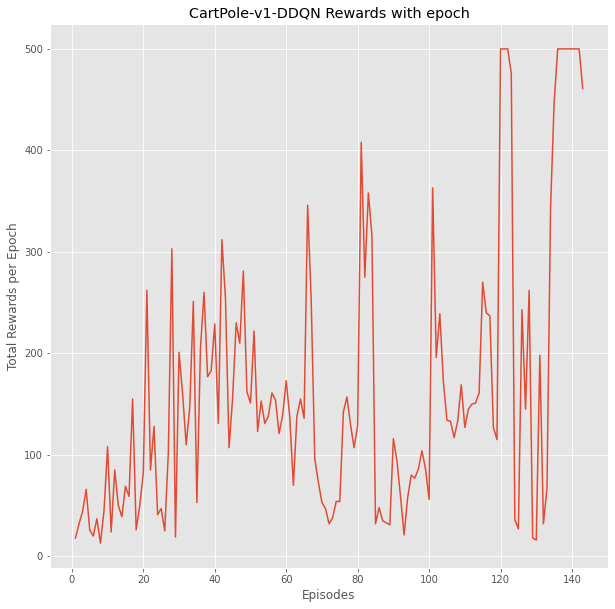

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


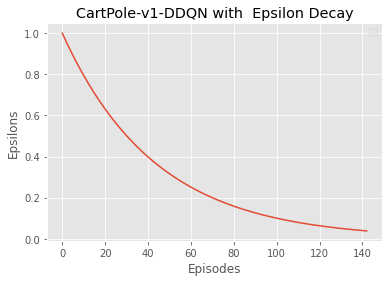

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


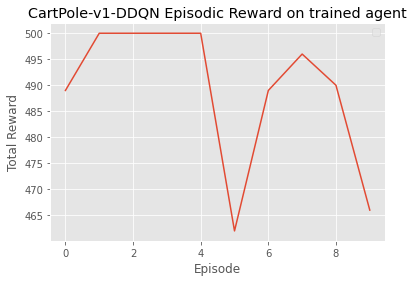

In [144]:
epochs,total_reward_list_ddqn, epsilons_epoch_ddqn =  train_model(env, model, loss_function, state_function= state_function, epochs= hyperparameters['episodes'], gamma= hyperparameters['gamma'], epsilon= hyperparameters['epsilon'],
 replay_buffer_size= hyperparameters['replay_buffer_size'], 
 batch_size = hyperparameters['replay_batch_size'], update_target_every= hyperparameters['update_target_every'],
  epsilon_min= hyperparameters['epsilon_min'], 
 epsilon_decay= (0.01 / 1)**(1/hyperparameters['episodes']), goal_threshold_score = hyperparameters['goal_threshold_score'] 
 ,goal_threshold_episodes =  hyperparameters['goal_threshold_episodes'], isDDQN=True) 

visualize_training(total_reward_list_ddqn, epochs, epsilons_epoch_ddqn, 'CartPole-v1', 'DDQN')
test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = env, state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'CartPole-v1', 'DDQN')
env.close()

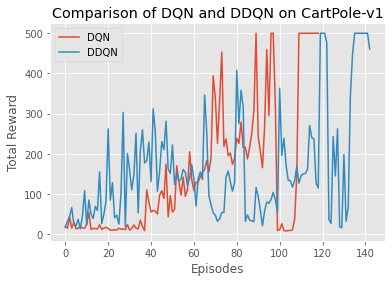

In [149]:
# comparing dqn and ddqn on the Cartpole-v1

plt.plot(range(len(epsilons_epoch_dqn)), total_reward_list_dqn, label='DQN')
plt.plot(range(len(epsilons_epoch_ddqn)), total_reward_list_ddqn, label='DDQN')
plt.title('Comparison of DQN and DDQN on CartPole-v1')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

<center><b> Lunar Lander v2</b></center>

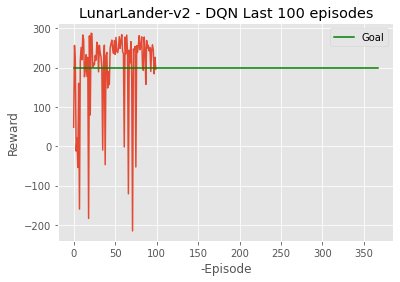

Epoch: 368 	 Total Reward: 242.35933118122784 	 Epsilon: 0.014454397707459382
Goal Reached!!


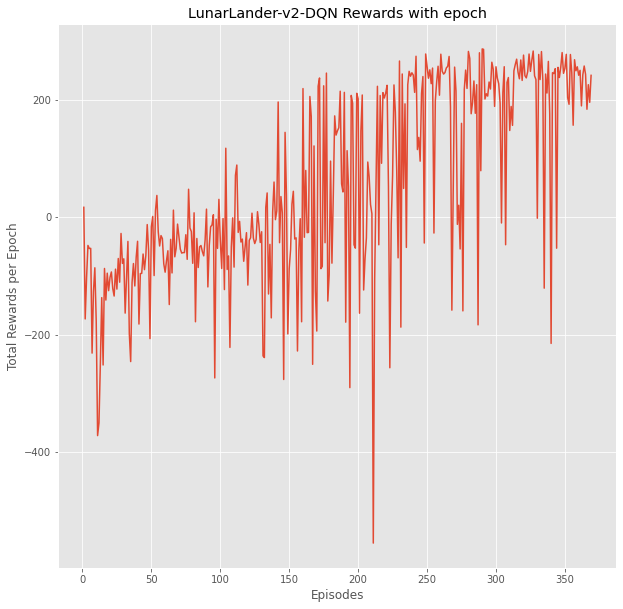

ValueError: x and y must have same first dimension, but have shapes (369,) and (370,)

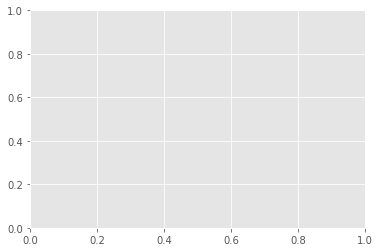

In [156]:
# Lunar lander

env = gym.make('LunarLander-v2')
env.reset()

# possible actions
print(f'Possible actions are Discrete: {env.action_space}')

# observation space
print(f'observation space consists of {env.observation_space}')

# goals
print(f'Goal threshold of the environment: {env.spec.reward_threshold}')


lunar_lander_hyperparameters  = {
    'state_dim': env.observation_space.shape[0],
    'action_dim': env.action_space.n,
    'layer_dim': [150, 120],
    'lr': 0.001,
    'episodes': 400,
    'gamma': 0.99,
    'replay_batch_size': 64,
    'epsilon': 1,
    'epsilon_min': 0.01,
    'replay_buffer_size': 100000,
    'update_target_every': 4,
    'goal_threshold_score': env.spec.reward_threshold,
    'goal_threshold_episodes': 100,
}

model = build_model(lunar_lander_hyperparameters)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lunar_lander_hyperparameters['lr'])

loss_function = torch.nn.MSELoss()

state_function = lambda env, curr_state: curr_state.to(device) if torch.is_tensor(curr_state) else torch.from_numpy(curr_state.reshape(1, 8)).float().to(device)

# mean of last 10 episodes is greater than 470

epochs,total_reward_list_dqn, epsilons_epoch_dqn =  train_model(env, model, loss_function, state_function= state_function, epochs= lunar_lander_hyperparameters['episodes'], gamma= lunar_lander_hyperparameters['gamma'], epsilon= lunar_lander_hyperparameters['epsilon'],
 replay_buffer_size= lunar_lander_hyperparameters['replay_buffer_size'], 
 batch_size = lunar_lander_hyperparameters['replay_batch_size'], update_target_every= lunar_lander_hyperparameters['update_target_every'],
  epsilon_min= lunar_lander_hyperparameters['epsilon_min'], 
 epsilon_decay= (0.01 / 1)**(1/lunar_lander_hyperparameters['episodes']), goal_threshold_score = lunar_lander_hyperparameters['goal_threshold_score'] ,goal_threshold_episodes =  lunar_lander_hyperparameters['goal_threshold_episodes']) 


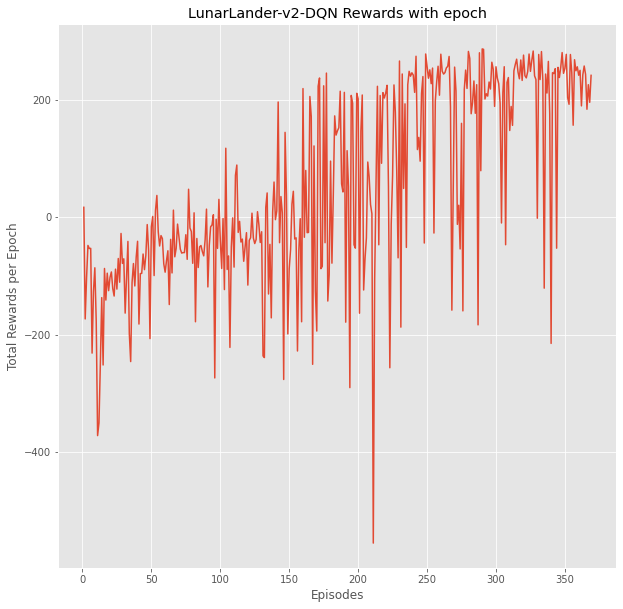

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


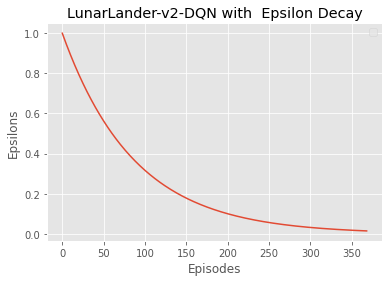

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


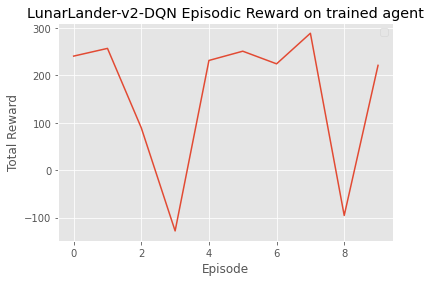

In [159]:
visualize_training(total_reward_list_dqn, epochs, epsilons_epoch_dqn, 'LunarLander-v2', 'DQN')
test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = env, state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'LunarLander-v2', 'DQN')

<center>MoonLander-v1 using Double DQN<center>

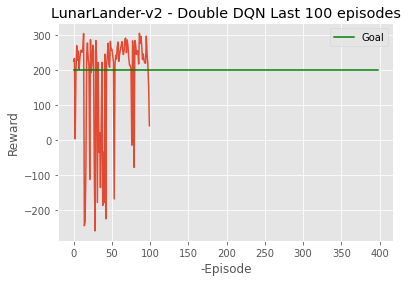

Epoch: 399 	 Total Reward: 249.69753338989753 	 Epsilon: 0.010115794542599066


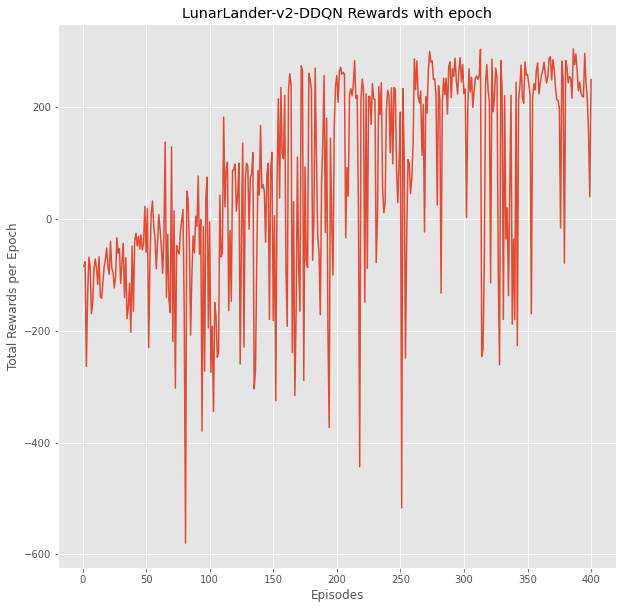

ValueError: x and y must have same first dimension, but have shapes (400,) and (401,)

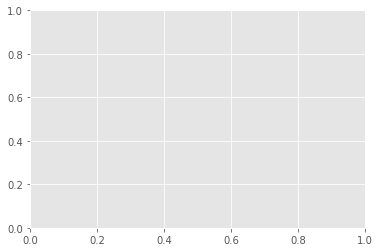

In [160]:
# Moon lander using Double DQN

epochs,total_reward_list_ddqn, epsilons_epoch_ddqn =  train_model(env, model, loss_function, state_function= state_function, epochs= lunar_lander_hyperparameters['episodes'], gamma= lunar_lander_hyperparameters['gamma'], epsilon= lunar_lander_hyperparameters['epsilon'],
 replay_buffer_size= lunar_lander_hyperparameters['replay_buffer_size'], 
 batch_size = lunar_lander_hyperparameters['replay_batch_size'], update_target_every= lunar_lander_hyperparameters['update_target_every'],
  epsilon_min= lunar_lander_hyperparameters['epsilon_min'], 
 epsilon_decay= (0.01 / 1)**(1/lunar_lander_hyperparameters['episodes']), goal_threshold_score = lunar_lander_hyperparameters['goal_threshold_score'] ,goal_threshold_episodes =  lunar_lander_hyperparameters['goal_threshold_episodes'],
 isDDQN= True) 

visualize_training(total_reward_list_ddqn, epochs, epsilons_epoch_ddqn, 'LunarLander-v2', 'DDQN')
test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = env, state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'LunarLander-v2', 'DDQN')
env.close()

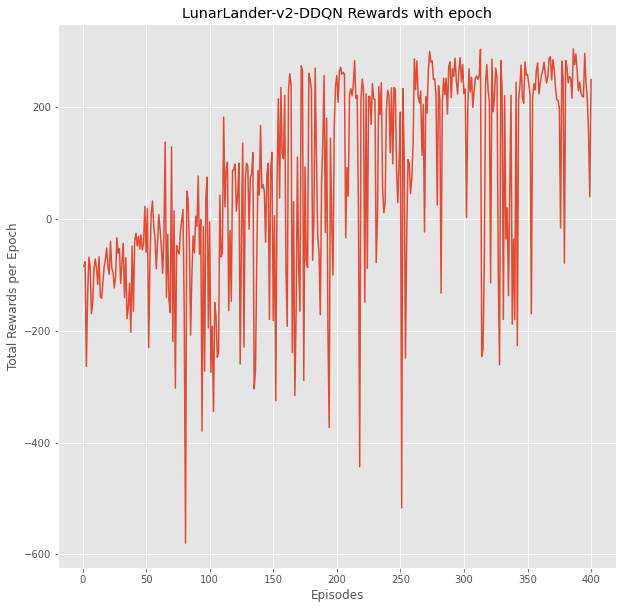

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


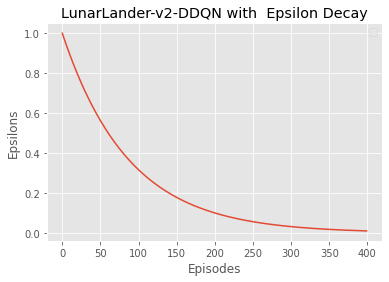

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


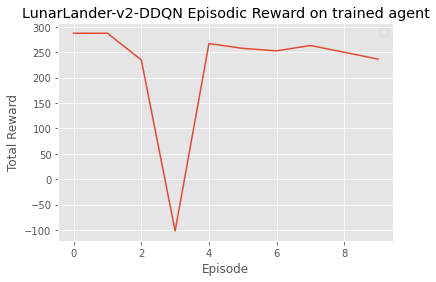

In [163]:

visualize_training(total_reward_list_ddqn, epochs, epsilons_epoch_ddqn, 'LunarLander-v2', 'DDQN')
test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = env, state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'LunarLander-v2', 'DDQN')

<center>Comparing DQN and DDQN on LunarLander-v2</center>

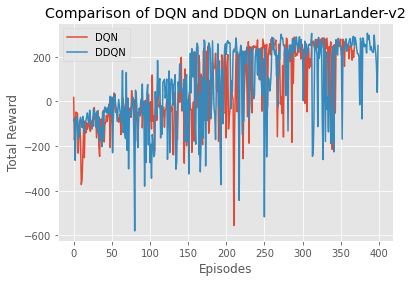

In [164]:
# comparing dqn and ddqn on the LunarLander-v2

plt.plot(range(len(epsilons_epoch_dqn)), total_reward_list_dqn, label='DQN')
plt.plot(range(len(epsilons_epoch_ddqn)), total_reward_list_ddqn, label='DDQN')
plt.title('Comparison of DQN and DDQN on LunarLander-v2')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()